In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

ratings_df  = pd.read_pickle("../../data/processed/rating_engage.pkl")
ratings_df = ratings_df[ratings_df["rating"] > 0].reset_index(drop=True)
ratings_df 

,user_id,item_id,rating,item_len
0,0,556,2.0,93
1,0,843,2.0,93
2,0,1039,5.0,93
3,0,3865,5.0,93
4,0,4646,3.0,93
...,...,...,...,...
263881,1999,94625,5.0,106
263882,1999,95168,4.0,106
263883,1999,96036,4.0,106
263884,1999,96165,5.0,106


In [2]:
unique_user_id = ratings_df['user_id'].unique()
unique_user_id = pd.DataFrame(data={
    'user_id': unique_user_id,
    'mapped_id': pd.RangeIndex(len(unique_user_id)),
})

unique_item_id = ratings_df['item_id'].unique()
unique_item_id = pd.DataFrame(data={
    'item_id': unique_item_id,
    'mapped_id': pd.RangeIndex(len(unique_item_id)),
})

In [3]:
ratings_user_id = pd.merge(ratings_df['user_id'], unique_user_id,
                            left_on='user_id', right_on='user_id', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mapped_id'].values)
ratings_item_id = pd.merge(ratings_df['item_id'], unique_item_id,
                            left_on='item_id', right_on='item_id', how='left')
ratings_item_id = torch.from_numpy(ratings_item_id['mapped_id'].values)

In [4]:
edge_index_user_to_item = torch.stack([ratings_user_id, ratings_item_id], dim=0)
edge_index_user_to_item

tensor([[    0,     0,     0,  ...,  1999,  1999,  1999],
        [    0,     1,     2,  ..., 23517, 31953, 22659]])

In [5]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

data = HeteroData()
data["user"].node_id = torch.arange(len(unique_user_id))
data["item"].node_id = torch.arange(len(unique_item_id))
data["user", "rates", "item"].edge_index = edge_index_user_to_item
data = T.ToUndirected()(data)

In [6]:
torch.save(data.to_dict(), "../../data/processed/graph.pkl")

In [7]:
x = HeteroData().from_dict(torch.load("../../data/processed/graph.pkl"))
x

HeteroData(
  user={ node_id=[2000] },
  item={ node_id=[97718] },
  (user, rates, item)={ edge_index=[2, 263886] },
  (item, rev_rates, user)={ edge_index=[2, 263886] }
)

In [8]:
data

HeteroData(
  user={ node_id=[2000] },
  item={ node_id=[97718] },
  (user, rates, item)={ edge_index=[2, 263886] },
  (item, rev_rates, user)={ edge_index=[2, 263886] }
)

In [9]:
data.metadata()

(['user', 'item'], [('user', 'rates', 'item'), ('item', 'rev_rates', 'user')])

In [10]:
NUM_NEI1, NUM_NEI2 = 100, 50
hidden_channels = 128
num_user = data["user"].num_nodes
num_item = data["item"].num_nodes

In [11]:
transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=("user", "rates", "item"),
    rev_edge_types=("item", "rev_rates", "user"), 
)
train_data, val_data, test_data = transform(data)

In [12]:
from torch_geometric.loader import LinkNeighborLoader


# Define seed edges:
edge_label_index = train_data["user", "rates", "item"].edge_label_index
edge_label = train_data["user", "rates", "item"].edge_label
train_loader = LinkNeighborLoader(
    data=train_data,
    num_neighbors=[NUM_NEI1, NUM_NEI2],
    neg_sampling_ratio=2.0,
    edge_label_index=(("user", "rates", "item"), edge_label_index),
    edge_label=edge_label,
    batch_size=1024,
    shuffle=True,
)

In [13]:
import numpy as np
import pandas as pd
import torch

# 주어진 numpy array와 pandas DataFrame
array = torch.tensor([1, 4, 3, 10, 144])
df = pd.DataFrame({
    "item_id": [1, 2, 3, 4, 5, 10, 144],
    "item_name": ['a', 'b', 'c', 'd', 'e', 'f', 'g']
})

# numpy array를 DataFrame으로 변환하여 merge 수행
array_df = pd.DataFrame(array, columns=['item_id'])
merged_df = pd.merge(array_df, df, on='item_id', how='left')

# 순서를 유지하며 item_name 추출
ordered_names = merged_df['item_name'].values

# 결과 출력
print(ordered_names)


['a' 'd' 'c' 'f' 'g']


In [14]:
edge_label_index = val_data["user", "rates", "item"].edge_label_index
edge_label = val_data["user", "rates", "item"].edge_label
val_loader = LinkNeighborLoader(
    data=val_data,
    num_neighbors=[NUM_NEI1, NUM_NEI2],
    edge_label_index=(("user", "rates", "item"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 1024,
    shuffle=False,
)

In [15]:
from torch_geometric.nn import GATv2Conv, to_hetero
import sys
sys.path.append("../")
from model import LinkPrediction
from torch import Tensor
import torch.nn as nn

import torch.nn.functional as F

        
model = LinkPrediction(hidden_channels=hidden_channels, num_user=num_user, num_item=num_item)

/home/isri/anaconda3/envs/fyi_39/lib/python3.9/site-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/home/isri/anaconda3/envs/fyi_39/lib/python3.9/site-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/home/isri/anaconda3/envs/fyi_39/lib/python3.9/site-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/home/isri/anaconda3/envs/fyi_39/lib/python3.9/site-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [16]:
import tqdm
from sklearn.metrics import roc_auc_score, roc_curve
import torch.nn.functional as F
from copy import deepcopy

best_auc = -float("inf")
model_parameters = deepcopy(model.state_dict())
patience = 3

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Device: '{device}'")
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


for epoch in range(1, 1000):
    total_loss = total_examples = 0
    for sampled_data in tqdm.tqdm(train_loader):
        optimizer.zero_grad()
        sampled_data.to(device)
        pred = model(sampled_data).squeeze()
        ground_truth = sampled_data["user", "rates", "item"].edge_label
        loss = F.binary_cross_entropy_with_logits(pred, ground_truth)
        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

    preds = []
    ground_truths = []
    for sampled_data in tqdm.tqdm(val_loader):
        with torch.no_grad():
            sampled_data.to(device)
            preds.append(model(sampled_data).squeeze())
            ground_truths.append(sampled_data["user", "rates", "item"].edge_label)
    pred = torch.cat(preds, dim=0).cpu().numpy()
    ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
    auc = roc_auc_score(ground_truth, pred)
    
    print(f"Validation AUC: {auc:.4f}")

    if(auc > best_auc):
        patience_counter=0
        model_parameters=deepcopy(model.state_dict())
        best_auc = auc
    else:
        patience_counter+=1
        if(patience_counter >= patience):
            print("early stop")
            break

Device: 'cuda'


100%|██████████| 62/62 [00:03<00:00, 15.51it/s]


Epoch: 001, Loss: 0.6375


100%|██████████| 26/26 [00:00<00:00, 28.84it/s]


Validation AUC: 0.5457


100%|██████████| 62/62 [00:04<00:00, 15.07it/s]


Epoch: 002, Loss: 0.6336


100%|██████████| 26/26 [00:00<00:00, 28.44it/s]


Validation AUC: 0.5545


100%|██████████| 62/62 [00:04<00:00, 15.44it/s]


Epoch: 003, Loss: 0.6193


100%|██████████| 26/26 [00:01<00:00, 21.14it/s]


Validation AUC: 0.6808


100%|██████████| 62/62 [00:03<00:00, 15.81it/s]


Epoch: 004, Loss: 0.5938


100%|██████████| 26/26 [00:01<00:00, 24.61it/s]


Validation AUC: 0.6853


100%|██████████| 62/62 [00:04<00:00, 13.63it/s]


Epoch: 005, Loss: 0.5875


100%|██████████| 26/26 [00:00<00:00, 28.83it/s]


Validation AUC: 0.6919


100%|██████████| 62/62 [00:04<00:00, 15.09it/s]


Epoch: 006, Loss: 0.5840


100%|██████████| 26/26 [00:01<00:00, 25.53it/s]


Validation AUC: 0.6852


100%|██████████| 62/62 [00:03<00:00, 16.26it/s]


Epoch: 007, Loss: 0.5814


100%|██████████| 26/26 [00:01<00:00, 25.88it/s]


Validation AUC: 0.6964


100%|██████████| 62/62 [00:03<00:00, 15.65it/s]


Epoch: 008, Loss: 0.5784


100%|██████████| 26/26 [00:00<00:00, 30.08it/s]


Validation AUC: 0.6958


100%|██████████| 62/62 [00:03<00:00, 17.00it/s]


Epoch: 009, Loss: 0.5776


100%|██████████| 26/26 [00:00<00:00, 33.27it/s]


Validation AUC: 0.6998


100%|██████████| 62/62 [00:04<00:00, 15.19it/s]


Epoch: 010, Loss: 0.5760


100%|██████████| 26/26 [00:00<00:00, 31.68it/s]


Validation AUC: 0.6981


100%|██████████| 62/62 [00:03<00:00, 17.41it/s]


Epoch: 011, Loss: 0.5745


100%|██████████| 26/26 [00:00<00:00, 33.82it/s]


Validation AUC: 0.7004


100%|██████████| 62/62 [00:03<00:00, 16.94it/s]


Epoch: 012, Loss: 0.5746


100%|██████████| 26/26 [00:00<00:00, 27.57it/s]


Validation AUC: 0.6966


100%|██████████| 62/62 [00:03<00:00, 16.05it/s]


Epoch: 013, Loss: 0.5739


100%|██████████| 26/26 [00:00<00:00, 27.90it/s]


Validation AUC: 0.7004


100%|██████████| 62/62 [00:03<00:00, 16.19it/s]


Epoch: 014, Loss: 0.5740


100%|██████████| 26/26 [00:00<00:00, 29.45it/s]

Validation AUC: 0.6968
early stop


## Test

In [17]:
model.load_state_dict(model_parameters)
best_auc

0.7004470703475006

In [18]:
edge_label_index = test_data["user", "rates", "item"].edge_label_index
edge_label = test_data["user", "rates", "item"].edge_label
test_loader = LinkNeighborLoader(
    data=test_data,
    num_neighbors=[NUM_NEI1, NUM_NEI2],
    edge_label_index=(("user", "rates", "item"), edge_label_index),
    edge_label=edge_label,
    batch_size=3 * 1024,
    shuffle=False,
)

In [19]:
from sklearn.metrics import roc_auc_score, roc_curve
preds = []
ground_truths = []
for sampled_data in tqdm.tqdm(test_loader):
    with torch.no_grad():
        sampled_data.to(device)
        preds.append(model(sampled_data).squeeze())
        ground_truths.append(sampled_data["user", "rates", "item"].edge_label)
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()


100%|██████████| 26/26 [00:00<00:00, 31.48it/s]


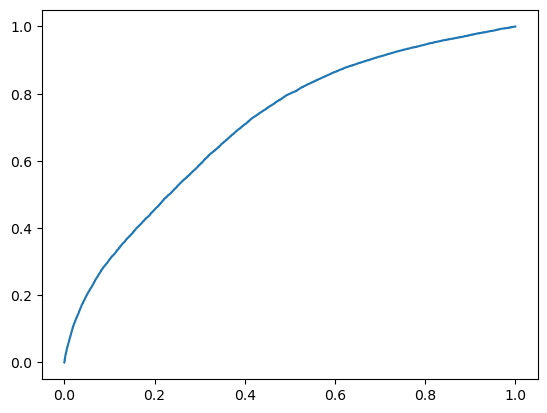

In [20]:
import matplotlib.pyplot as plt

fprs, tprs, th = roc_curve(ground_truth, pred)

plt.plot(fprs, tprs)

In [21]:
torch.save({
    "state_dict": model.cpu().state_dict(), 
    "hidden_channels": hidden_channels, 
    "num_user": num_user,
    "num_item": num_item,
    "num_nei1": NUM_NEI1,
    "num_nei2": NUM_NEI2,
}, "../parameters/linkprediction.pth")